In [1]:
import numpy as np 
import skimage.io as io
import keras
import os
import glob
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


# EDA

In [4]:
datapath = os.getcwd()+'/train'

In [5]:
os.getcwd()

'/home/kray/Practicum'

In [9]:
datalist = os.listdir(datapath)
len(datalist)

3

In [10]:
datalist[0]

'Type_3'

In [11]:
#Fetch the paths for images
Type_1 = glob.glob(datapath+'/Type_1/*.jpg')
Type_2 = glob.glob(datapath+'/Type_2/*.jpg')
Type_3 = glob.glob(datapath+'/Type_3/*.jpg')

In [12]:
Type_1[0]

'/home/kray/Practicum/train/Type_1/102.jpg'

In [13]:
print(len(Type_1))
print(len(Type_2))
print(len(Type_3))

250
781
450


In [14]:
im = io.imread(Type_1[0])
print(type(im),im.shape) 

<class 'numpy.ndarray'> (3264, 2448, 3)


In [15]:
# check the image dimension
for Type_1_file in Type_1[:10]:
    print(io.imread(Type_1_file).shape)

(3264, 2448, 3)
(4128, 3096, 3)
(4160, 3120, 3)
(4128, 3096, 3)
(4160, 3120, 3)
(3096, 4128, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(4128, 3096, 3)
(4128, 3096, 3)


In [16]:
# check the image dimension
for Type_2_file in Type_2[:10]:
    print(io.imread(Type_2_file).shape)

(3264, 2448, 3)
(3264, 2448, 3)
(4128, 3096, 3)
(3264, 2448, 3)
(4128, 3096, 3)
(4128, 3096, 3)
(4128, 3096, 3)
(3264, 2448, 3)
(4128, 3096, 3)
(4128, 3096, 3)


In [17]:
# check the image dimension
for Type_3_file in Type_3[:10]:
    print(io.imread(Type_3_file).shape)

(4128, 3096, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(640, 480, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(3264, 2448, 3)
(4128, 3096, 3)


In [18]:
#mean of the x column of the first 10 images
np.mean([io.imread(t).shape[0] for t in Type_1[:10]])

3772.0

In [19]:
#mean of the y column of the first 10 images
np.mean([io.imread(t).shape[1] for t in Type_1[:10]])

3009.5999999999999

In [20]:
np.mean([io.imread(t).shape[0] for t in Type_2[:10]])

3782.4000000000001

In [21]:
np.mean([io.imread(t).shape[1] for t in Type_2[:10]])

2836.8000000000002

In [22]:
np.mean([io.imread(t).shape[0] for t in Type_3[:10]])

3174.4000000000001

In [23]:
np.mean([io.imread(t).shape[1] for t in Type_3[:10]])

2380.8000000000002

In [24]:
#max pixal value
im.max()

255

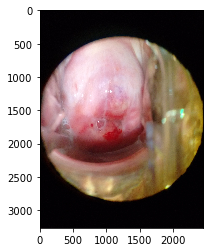

In [26]:
plt.imshow(im)

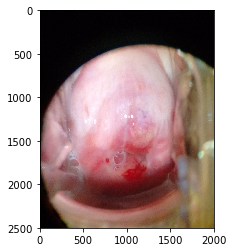

In [29]:
imc = im[:2500, :2000,:] #cropping array row-> y, column-> x
plt.imshow(imc)

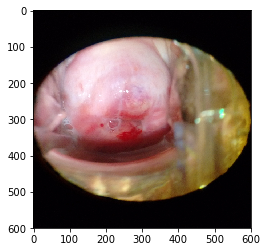

In [31]:
from skimage.transform import resize
imc = resize(im, (600,600,3))
plt.imshow(imc)

In [32]:
imc.max()

1.0

In [34]:
XType_1 = np.array([resize(io.imread(Type_1_file), (256,256,3)) for Type_1_file in Type_1])
XType_2 = np.array([resize(io.imread(Type_2_file), (256,256,3)) for Type_2_file in Type_2])
XType_3 = np.array([resize(io.imread(Type_3_file), (256,256,3)) for Type_3_file in Type_3])
X = np.concatenate([XType_1, XType_2, XType_3], axis=0)
#y = np.concatenate([np.zeros(len(Type_1)), np.ones(len(Type_2))], axis=0)
# There is a better way to do it in smaller batches in a lazy evaluation when you use a generator.

ValueError: Could not load "" 
Reason: "image file is truncated (54 bytes not processed)"
Please see documentation at: http://pillow.readthedocs.org/en/latest/installation.html#external-libraries

In [3]:
y.shape

# Preprocessing
Neural net is most comfortable when the image has pixel values normalized.
Also the optimization works best when the images have zero mean.

In [4]:
# Let's have a look what the mean, max and min pixel values for each channel.
for i in range(3):
    print(X[:,:,:,i].max(), X[:,:,:,i].min(), X[:,:,:,i].mean())

NameError: name 'X' is not defined

Note that the original images pixel values scale from 0 to 255 (check with im.max()), but after skimage.transform.resize, it automatically changed to 0-1 scale (check with imc.max()). This is not true for open cv. So always check your pixel value ranges and rescale it. Now, we are going to make it a zero mean.

In [18]:
means = [X[:,:,:,i].mean() for i in range(3)]
maxs = [X[:,:,:,i].max() for i in range(3)]
mins = [X[:,:,:,i].min() for i in range(3)]
Xn = np.concatenate([np.expand_dims((X[:,:,:,i]-means[i])/(maxs[i]-mins[i]), axis=3) for i in range(3)], axis=3) 

In [22]:
Xn[0,:,:,0].mean()

0.056868668805514722

In [23]:
for i in range(3):
    print(Xn[:,:,:,i].std())    

0.261212055798
0.254647858671
0.257261026162


# Build a model
Now we have data set ready, let's build a convolutional neuralnet model.

In [24]:
import keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import SGD
from sklearn.utils import shuffle
from keras.utils.np_utils import to_categorical

In [25]:
Y = to_categorical(y)
Xtr, ytr = shuffle(Xn,Y,random_state=0)

In [26]:
model = Sequential()
model.add(Convolution2D(16,3,3, input_shape=(32,32,3), border_mode="same", activation='relu'))
model.add(Flatten())
model.add(Dense(512))
model.add(Dense(2))
model.add(Activation('softmax'))
sgd = SGD(lr=0.01, decay=0.01, momentum=0.9)
model.compile(optimizer=sgd, loss="categorical_crossentropy", metrics=['acc']) 

In [ ]:
model.fit(Xtr, ytr, batch_size=32, nb_epoch=15) #Note that nb_epoch has changed to epochs in keras 2.0

Epoch 1/15
 2080/25000 [=>............................] - ETA: 312s - loss: 0.6739 - acc: 0.5870 

### To Do
6) Play with hyper parameters such as filter numbers, nb_epoch, batch_size, learning rate lr, decal and momentum and discuss which hyper parameters had the best effect on the accuracy.    
7) Read the documentation for conv2d and try other options https://keras.io/layers/convolutional/#conv2d    
8) Try Adam optimization. Read https://keras.io/optimizers/ Search web what Adam optimizer does and compare what advantage it has over plain SGD.    
9) Try different activation functions in conv layer(s) or in dense layer(s) https://keras.io/activations/    
10) Add mode conv layers and see if your results increase.    